Preamble:

1. The syspath for module imports might have to be changed to allow proper importing of the submodules of this project.
2. I am using a nonstandard plotting library called plotly. It might not be installed on your machine. If this causes problems, I can upload the figures as well.

In [1]:
import sys
path = "../src"
sys.path.append(path) # go to parent dir

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from binaryOps import *
from operators import *
from indexMaps import *
import numpy as np
from numpy import linalg as lina
from scipy.sparse import linalg as spla
import time as t


Table of Contents:

1. [Construction of the Hamiltonian and full diagonalisation](#1.1)
    1. [Construction of the Hamiltonian](#1.1a)
    2. [Diagonalising the Hamiltonian](#1.1b)
    3. [Construction of the Hamiltonian with Conservation Laws](#1.1c)
    4. [Performance with Conservation Laws](#1.1d)


2. [Exact diagonalization using the Lanczos method:](#1.2)
    1. [Ground State values without conservation laws](#1.2a)
    2. [Ground state values with conservation laws](#1.2b)
    3. [Comparsion of Performance](#1.2c)
    4. [Spin Gap Calculation](#1.2d)


# Project 1: Full and exact diagonalization of one-dimensional spin-$\frac{1}{2}$ Heisenberg model

## 1.1 Construction of the Hamiltonian and full diagonalisation <a class="anchor" id="1.1"></a>

### 1.1a) Construction of the Hamiltonian <a class="anchor" id="1.1a"></a>

To construct the Hamiltonian in the Heisenberg model, we need 3 things:

First, the basis elements need to be mapped to a set of indices and/or vice versa, to allow efficient iteration over them. 

Secondly, we need define operations on the basis elements corresponding to the spin operators $S_j^{\pm}$ and $S_j^z$, modeling the action of the Hamiltonian.

Thirdly, we can use this mapping between indices and basis elements to and the corresponding operations to actually calculate the Hamiltonian matrix elements, thereby constructing the Hamiltonian.


#### 1) Mapping basis elements to indices

An elegant way to represent basis elements is via a binary representation, where each 0 stands for a down spin electron, and each 1 for an up spin electron. These basis elements, represented as binary numbers, can then arbitrarily be mapped to indices and vice versa. In fact, if we create a table mapping basis elements to indices and also a table to map indices to basis elements, we can speed up the construction of the Hamiltonian at the cost of some memory, which we shall do here.

For a Hamiltonian of size $LxL$, we need all binary numbers of length L to represent all possible basis states. If we use a conservation law, we can reduce the number and only allow states with certain total spin, i.e. only binary numbers with certain amounts of 1s and 0s. To be able to include this restriction, we can define a function that calculates the amount of 0s and 1s in a binary number and from that gives the total spin. Since Python gives the binary representation of a number as a string, we can simply count the number of 0s and 1s in the string for this.

In [4]:
# 3 Spin up 1 spin down represented via 1011 or 11 gives a total spin of 2*1/2=1:
print(binary(11))
print(total_spin(11,4))

1011
1.0


Now we can construct a dictionary mapping these integers/binary numbers to indices, either imposing total spin conservation or not:

In [5]:
# Create a dictionary for a total spin of 1, i.e. 3 up and 1 down spin
isDict = create_index_to_state(4, totalSpin = 1)
print(isDict)
print([binary(elem).zfill(4) for k, elem in isDict.items()]) # binary representations of the integers

{0: 7, 1: 11, 2: 13, 3: 14}
['0111', '1011', '1101', '1110']


In [6]:
# and the reverse dictionary
siDict = create_state_to_index(isDict)
print(siDict)

{7: 0, 11: 1, 13: 2, 14: 3}


#### 2) Representig operator action

Now we want to represent the action of the $S^+_j S^-_{j+1}$ and $S^-_j S^+_{j+1}$ terms. These simply flip two neighboring bits if they are unequal, and have no contribution if two neighboring bits are equal, i.e. the electrons have the same spin.

So if we look at "1011" (11 in decimal), our function representing those operators should flip the first 1 and  0, and the 0 and next 1, but nothing more.

In [7]:
x = 11
binary(x)

'1011'

In [8]:
# Swapping at index 0, nothing should happen
y = swap_unequal_neighbors(x,0,4)
binary(y).zfill(4)

'1011'

In [9]:
# Swapping at index 1
y = swap_unequal_neighbors(x,1,4)
binary(y).zfill(4)

'1101'

In [10]:
# Swapping at index 2
y = swap_unequal_neighbors(x,2,4)
binary(y).zfill(4)

'0111'

In [11]:
# Creating a list of outcoming states if applying ladder operators at all indices:
l = calculate_ladder_operators(x,4)
print([binary(elem).zfill(4) for elem in  l])

['1101', '0111']


And me can calculate the total $S^z$ coupling going into the diagonal element of the Hamiltonian by simply iterating over the binary  representation and multiplying the corresponding spins:

In [12]:
x=10
binary(x).zfill(4)

'1010'

In [13]:
calculate_sz_coupling(x,4)

-1.0

#### 3) Constructing the Hamiltonian:

Finally, we can use all of these ideas to construct the Hamiltonian for given system size (here L = 3)

In [14]:
L = 3

In [15]:
print([binary(elem).zfill(L) for k, elem in create_index_to_state(L).items()]) # States for L = 3

['000', '001', '010', '011', '100', '101', '110', '111']


In [16]:
construct_hamiltonian(L).todense()

matrix([[ 0.75,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 0.  , -0.25,  0.5 ,  0.  ,  0.5 ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.5 , -0.25,  0.  ,  0.5 ,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , -0.25,  0.  ,  0.5 ,  0.5 ,  0.  ],
        [ 0.  ,  0.5 ,  0.5 ,  0.  , -0.25,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.5 ,  0.  , -0.25,  0.5 ,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.5 ,  0.  ,  0.5 , -0.25,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.75]])

### 1.1b) Diagonalising the Hamiltonian<a class="anchor" id="1.1b)"></a>

We can simply use the numpy diagonalisation method for dense matrices, or apply the method from scipy sparse for sparse matrices. We will use the first option here, as it is more efficient for small matrices. The second option however is more efficient if one only desires the lowest eigenvalues, as it uses a Lanczos method to compute a desired amount of values. We also sort the eigenvalues, and the corresponding eigenvectors, in ascending order for future use.

In [17]:

def diagonalise(M):
    ew, ev = lina.eig(M)
    sorted_index = ew.argsort()
    ew = ew[sorted_index]
    ev = ev[:,sorted_index]
    return ew, ev

def diagonalise_sparse(M, k = 1):
    N = M.get_shape()[0]
    if (N > 1):
        ew,ev = spla.eigsh(M, k = k) # Use the method for hermetian/symmetric matrices
        sorted_index = ew.argsort()
        ew = ew[sorted_index]
        ev = ev[:,sorted_index]
        return ew, ev
    return [M.todense()[0][0]],[1]

and we wish to compare computing times and memory usage, so let us define a function that does so. We use sys.getsizeof of our hamiltonian to estimate the memory usage here.

In [18]:
def construct_and_diagonalise(systemSize, totalSpin = None):
    start = t.time()
    H = construct_hamiltonian(systemSize, totalSpin = totalSpin)
    construction_time = t.time()-start
    H = H.todense()
    ew, ev = diagonalise(H)
    total_time = t.time()-start
    return (total_time, H.nbytes, construction_time)

In [19]:
noConservationPerformance = np.array([construct_and_diagonalise(2*i) for i in range(1,7)])

In [20]:
noConservationPerformance

array([[0.00000000e+00, 1.28000000e+02, 0.00000000e+00],
       [1.00398064e-03, 2.04800000e+03, 1.00398064e-03],
       [2.99501419e-03, 3.27680000e+04, 2.99501419e-03],
       [4.09791470e-02, 5.24288000e+05, 1.19791031e-02],
       [5.51000118e-01, 8.38860800e+06, 5.50005436e-02],
       [2.54050136e+01, 1.34217728e+08, 2.58028269e-01]])

Interestingly, the amount of time to construct the Hamiltonian is not as large as thje diagonalisation time!

In [21]:
times = noConservationPerformance[:,0]
memory = noConservationPerformance[:,1]
lengths = [2*i for i in range(1,7)]

In [22]:
times

array([0.00000000e+00, 1.00398064e-03, 2.99501419e-03, 4.09791470e-02,
       5.51000118e-01, 2.54050136e+01])

In [23]:
fig = make_subplots(rows=1, cols=2,
    x_title="System size",
    y_title="Time to construct and diagonalise in seconds",)

fig.add_trace(
    go.Scatter(x=lengths, y=times, name = "time", mode = "markers"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=lengths, y=times, name = "Time on a logscale", mode = "markers"),
    row=1, col=2
)
fig.update_yaxes(type="log", dtick= 1, row=1, col=2)

fig.update_layout(
    height=600, width=800,
    title="Construction and diagonalisation times without conservation laws",
)
fig.show()

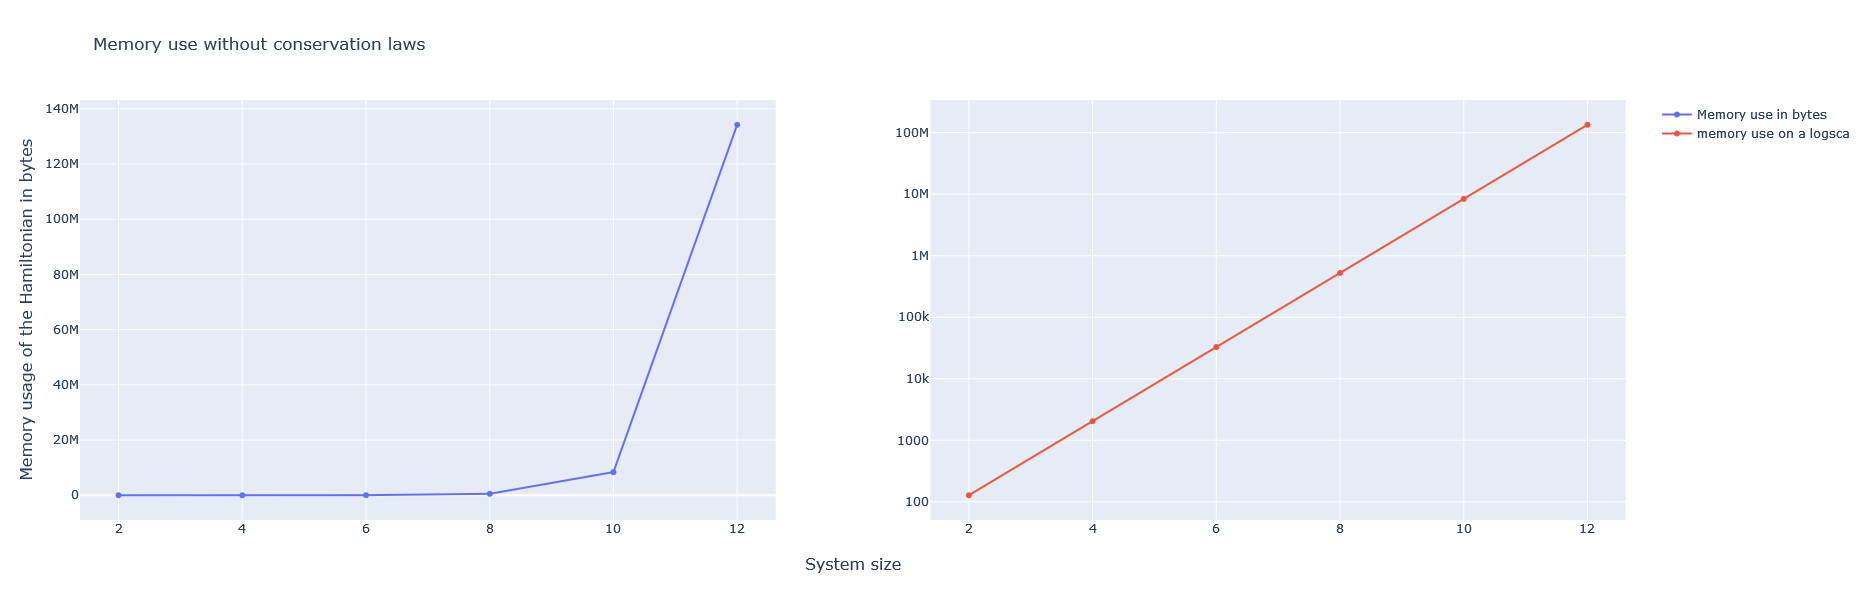

In [24]:
fig = make_subplots(rows=1, cols=2,     
    x_title="System size",
    y_title="Memory usage of the Hamiltonian in bytes",)

fig.add_trace(
    go.Scatter(x=lengths, y=memory, name ="Memory use in bytes"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=lengths, y=memory, name ="memory use on a logscale"),
    row=1, col=2
)
fig.update_yaxes(type="log", dtick= 1, row=1, col=2)

fig.update_layout(
     height=600, width=800,
    title="Memory use without conservation laws"
)
fig.show()

As we can see, the time to compute seems to scale exponentially: For only a system size of 12 we already require a significant amount of computation time, namely aroubnd 25 seconds on this machine. As for the memory usage, it scales exponentially as $2^L$, as expected.

### 1.1c) Constructing the Hamiltonian with conservation laws<a class="anchor" id="1.1c"></a>

Our functions above already can do the construction with conservation laws, just define a total spin for an example:

In [25]:
L = 4
totalSpin = 1

In [26]:
print([binary(elem).zfill(L) for k, elem in create_index_to_state(L, totalSpin = totalSpin).items()]) # States for L = 4

['0111', '1011', '1101', '1110']


In [27]:
construct_hamiltonian(L, totalSpin = totalSpin)

<4x4 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

### 1.1d) Performance with Conservation Laws <a class="anchor" id="1.1d"></a>

First define a function that constructs all partial Hamiltonians of size L:

In [28]:
def construct_and_diagonalise_all(systemSize):
    start = t.time()
    maxSpin = systemSize/2
    usedMemory = 0
    for spin in np.arange(-maxSpin,maxSpin+1):
        loopStart = t.time()
        time, memory, constrTime = construct_and_diagonalise(systemSize, totalSpin = spin)
        usedMemory = usedMemory + memory
        if (spin == 0): # Matrix of Maximum Size is exactly at total spin 0, as that allows for the maximal number of permutations
            maxmem = memory
            maxtime = t.time() - loopStart
    return maxtime, maxmem, (t.time()-start), usedMemory

Now we can just test the performance

In [29]:
ConservationPerformance = np.array([construct_and_diagonalise_all(2*i) for i in range(1,7)])

In [30]:
times = ConservationPerformance[:,0]
memory = ConservationPerformance[:,1]
lengths = [2*i for i in range(1,7)]

In [31]:
fig = make_subplots(rows=1, cols=2,
        x_title="System size",
        y_title="Time to construct and diagonalise in seconds")

fig.add_trace(
    go.Scatter(x=lengths, y=times, name = "time", mode = "markers"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=lengths, y=times, name = "Time on a logscale", mode = "markers"),
    row=1, col=2
)
fig.update_yaxes(type="log", dtick= 1, row=1, col=2)

fig.update_layout(
    height=600, width=800,
    title="Construction and diagonalisation times with conservation laws",
)
fig.show()

As we can see, the time to compute seems to continue scaling exponentially, but to a lesser degree: Diagonalising all Subhamiltonians only takes around 1.4 seconds, so a reduction by about an order of magnitude, which is quite significant!

In [32]:
fig = make_subplots(rows=1, cols=2,
    x_title="System size",
    y_title="Memory usage of the Hamiltonian in bytes",)

fig.add_trace(
    go.Scatter(x=lengths, y=memory),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=lengths, y=memory),
    row=1, col=2
)
fig.update_yaxes(type="log",dtick= 1, row=1, col=2)

fig.update_layout(
     height=600, width=800,
    title="Memory use with conservation laws",
)
fig.show()

Similarly, the memory usage also increases exponentially, but it is about an order of magnitude less than in the case without conservation laws.

# 1.2 Exact diagonalization using the Lanczos method <a class="anchor" id="1.2"></a>

First, we of course need to implement the Lanczos method.  This is done in lanczos.py, and here we simply test whether the method correctly calculates the ground state energy of our given Hamiltonian. We can do that via this small script:

In [33]:
from lanczos import *

In [34]:
L = 6
Kmax = 20

In [35]:
H = construct_hamiltonian(L)
HDense = H.todense()

ew, ev = lanczos_ev(H,np.random.rand(2**L),Kmax)

ew2 = diagonalise(HDense)[0][0]

print("Same lowest eigenvalues: " + str(np.allclose(ew,ew2)))
print("Eigenvalue: " + str(ew))

evCheck = np.allclose(np.matmul(HDense, ev), ew*ev)

print("Same eigenvector: " + str(evCheck))
ev[np.abs(ev) < 10**(-8)] = 0
print("Eigenvector: " + str(ev))

Same lowest eigenvalues: True
Eigenvalue: -2.8027756377319935
Same eigenvector: True
Eigenvector: [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.06292062+0.j
  0.        +0.j  0.        +0.j  0.        +0.j -0.2078127 +0.j
  0.        +0.j  0.2078127 +0.j -0.06292062+0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.2078127 +0.j
  0.        +0.j -0.47854601+0.j  0.2078127 +0.j  0.        +0.j
  0.        +0.j  0.2078127 +0.j -0.2078127 +0.j  0.        +0.j
  0.06292062+0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j -0.06292062+0.j
  0.        +0.j  0.2078127 +0.j -0.2078127 +0.j  0.        +0.j
  0.        +0.j -0.2078127 +0.j  0.47854601+0.j  0.        +0.j
 -0.2078127 +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.06292062+0.j -0.2078127 +0.j  0.        +0.j
  0.2078127 +0.j  0.        +0.j  0.        +0.j  0.     

## 1.2a) Ground State values without conservation laws <a class="anchor" id="1.2a"></a>

To calculate the ground state values without conservation laws, we now simply apply the Lanczos algorithm for the desired sysdtem sizes. We can also immediately compare used memory and calculation times.
To estimate memory usage, we will again simply use the memory needed for the matrix, as the memory needed for the 3 vectors in the Lanczos algorithm is negligible compared to the matrix size.

In [36]:
def sparse_memory_usage(M):
    try:
        return M.data.nbytes + M.indptr.nbytes + M.indices.nbytes
    except AttributeError:
        return -1

In [37]:
def calc_ground_state(systemSizes, Kmax):
    """
    Calculates the ground state and its eigenenergy for desired system sizes.
    Returns a dictionary of system sizes and the corresponding eigenvalues and states, as well as a dictionary of system sizes and times needed  to calculate that information
    """
    res = {}
    times = {}
    memory = {}
    for L in systemSizes:
        start = t.time()
        H = construct_hamiltonian(L)
        ew, ev = lanczos_ev(H,np.random.rand(2**L),Kmax)
        res[L] = (ew,ev)
        times[L] = t.time()-start
        memory[L] = sparse_memory_usage(H)
    return res, times, memory

In [38]:
systemSizes = [10,12,14,16,19,20]

In [39]:
wo_conv_res, wo_conv_times, wo_conv_memory = calc_ground_state(systemSizes,50)

So ground state eigenvalues, eigenvectors as well as calculation times and memory use for different system sizes can be seen in "wo_conv_res", "wo_conv_times", "wo_conv_memory" respectively.

## 1.2b) Ground state values with conservation laws <a class="anchor" id="1.2b)"></a>

We now do the same thing, just using conservation laws and calculating the ground state for all possible total spins for a given system size L

In [64]:
def calc_ground_state_conv(systemSize, Kmax):
    start = t.time()
    maxSpin = systemSize/2
    usedMemory = 0
    values= {}
    for spin in np.arange(-maxSpin,maxSpin+1):
        loopStart = t.time()
        H = construct_hamiltonian(systemSize, totalSpin = spin)
        Hsize = H.get_shape()[0]
        ew, ev = lanczos_ev(H,np.random.rand(Hsize),Kmax)
        values[spin] = (ew,ev)
        usedMemory = usedMemory + sparse_memory_usage(H)
        if (spin < 1 and spin >= 0):
            maxtime = t.time() - loopStart
            maxmem = sparse_memory_usage(H)
    return maxtime,maxmem,values, (t.time()-start), usedMemory

def calc_ground_states_conv(systemSizes, Kmax):
    res = {}
    times = {}
    memory = {}
    for L in systemSizes:
        usedTime, usedMemory, values, totalTime, totalMemory = calc_ground_state_conv(L,Kmax)
        res[L] = values
        times[L] = usedTime
        memory[L] = usedMemory
    return res, times, memory
    

In [65]:
w_conv_res, w_conv_times, w_conv_memory= calc_ground_states_conv(systemSizes, 50)

## 1.2c) Comparsion of Performance<a class="anchor" id="1.2c"></a>

In [66]:
L =systemSizes
times_wo_conv = np.array([*wo_conv_times.values()])
times_w_conv = np.array([*w_conv_times.values()])
memory_wo_conv = np.array([*wo_conv_memory.values()])
memory_w_conv = np.array([*w_conv_memory.values()])

In [75]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=L, y=times_wo_conv, name = "Calculation time without conservation laws"),
)
fig.add_trace(
    go.Scatter(x=L, y=times_w_conv,name = "Calculation time with conservation laws"),
)
fig.update_yaxes(type = "log", dtick= 1)
fig.update_layout(
    height=600, width=800,
    title=r"Calculation times with and without conservation laws",
    xaxis_title=r"System Size",
    yaxis_title=r"Calculation Time in seconds",
)
fig.show()

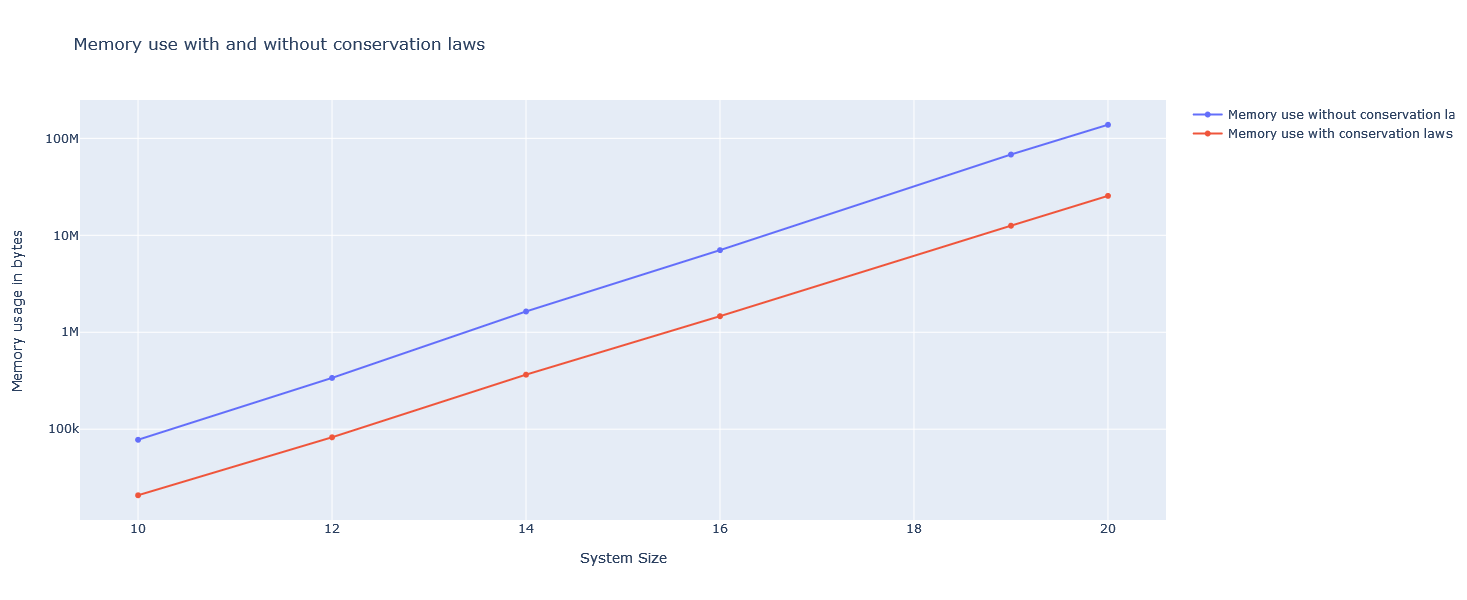

In [76]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=L, y=memory_wo_conv, name = "Memory use without conservation laws"),
)
fig.add_trace(
    go.Scatter(x=L, y=memory_w_conv,name = "Memory use with conservation laws"),
)
fig.update_yaxes(type = "log", dtick= 1)
fig.update_layout(
    height=600, width=800,
    title=r"Memory use with and without conservation laws",
    xaxis_title=r"System Size",
    yaxis_title=r"Memory usage in bytes",
)
fig.show()

For both calculation times and memory usage, we again see the same results: There is an exponential scaling in both computation time and used memory, however using conservation laws, we can reduce both of these factors by about an order of magnetude. However, the scaling is not affected, so conservation laws do not help us with simulating significantly larger systems.

## 1.2d) Spin Gap Calculation<a class="anchor" id="1.2d"></a>

For the spin gap calculation, we can simply define the two Hamiltonians for total spin 1/2 and 0, calculate their ground state eigenvalues, and thereby the spin gap for all desired lengths:

In [69]:
def spin_gap(systemSize, Kmax = 50):
    systemSize = np.array([systemSize]).flatten()
    spinGap = {}
    for L in systemSize:
        H1 = construct_hamiltonian(L, totalSpin = 1/2)
        H0 = construct_hamiltonian(L, totalSpin = 0)
        
        H1size = H1.get_shape()[0]
        H0size = H0.get_shape()[0]
        
        ew1, ev1 = lanczos_ev(H1,np.random.rand(H1size),Kmax)
        ew0, ev0 = lanczos_ev(H0,np.random.rand(H0size),Kmax)
        
        spinGap[L] = ew1-ew0
        
    return spinGap

In [70]:
spinGaps = spin_gap([2*i for i in range(3,11)])

In [71]:
# Plotting axes
x= 1/np.array([*spinGaps.keys()])
y = np.array([*spinGaps.values()])

In [72]:
from scipy import interpolate
# Extrapolation
f = interpolate.interp1d(x, y, fill_value='extrapolate')
x_new = np.linspace(0,0.2, 100)

In [73]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=x, y=y, name = "Simulated data"),
)
fig.add_trace(
    go.Scatter(x=x_new, y=f(x_new),name = "Extrapolation"),
)
fig.update_layout(
    height=600, width=800,
    title=r"$\text{Spin Gap } E_s \text{ with increasing system size } L \text{ for the Hubbard Model}$",
    xaxis_title=r"$\frac{1}{L}$",
    yaxis_title=r"$E_s$",
)
fig.show()

As we can see, the spin gap for the thermodynamic limit $L \rightarrow \infty$ or $ \frac{1}{L} \rightarrow 0$ takes on the value of approximately 16.84, if we extrapolate linearly from the largest points we have calculated.